# simulating a migrating population of bacteria 

In [1]:
import tsinfer
import tskit
import msprime
import tsdate

import numpy as np
import pandas as pd

import datetime as dt
import time

import matplotlib.pyplot as plt
%matplotlib inline 

# from sklearn.linear_model import LinearRegression
from itertools import combinations

# [!Note](https://tskit.dev/msprime/docs/latest/demography.html#model)

Migration is described from the perspective of the coalescent, so that when describing migrations in msprime, the following reversed terminology holds:

destination (or dest):
The population containing the immediate ancestors of the migrant(s). Forwards in time, this is where migrants come from. In reverse time, a lineage that is traced backwards in time (i.e. from the current day into the past) will appear to jump into this ancestral destination at the precise time of the migration event.

source:
The population containing the immediate descendants of the migrants. Forwards in time, this is where migrants end up. In reverse time, a lineage traced backwards from the current day will appear to jump from this population into the ancestral (“destination”) population.

In [2]:
# demographic model 
num_sinks = 2
sizes = [1e4] + [5e3] * num_sinks
bg = 1e-6 #background migration rate 
demography = msprime.Demography.island_model(initial_size=sizes, migration_rate=bg)

src_sink = 0.001 # source to sink mig rate
sink_src = 0.0000001 # sink to source mig rate
sink_sink = 0.00001 # sink to sink mig rate

# source to and from sink, assymetric
for sink_id in range(1, num_sinks + 1):
    demography.set_migration_rate(source=0,       dest=sink_id, rate=src_sink)  # source -> sink
    demography.set_migration_rate(source=sink_id, dest=0,       rate=sink_src)  # sink   -> source

# sink to and from sink, symmetric 
sink_ids = list(range(1, num_sinks + 1))
demography.set_symmetric_migration_rate(populations=sink_ids, rate=sink_sink)

# simulate ancestry 
ts = msprime.sim_ancestry(
    samples=[msprime.SampleSet(50, population=p) for p in range(num_sinks + 1)],
    demography=demography,
    sequence_length=1e5,
    random_seed=25,
    record_migrations = True
)

#mts = msprime.sim_mutations(ts, rate=1e-8, random_seed=25)

print(ts)


╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │          1║
╟───────────────┼───────────╢
║Sequence Length│    100,000║
╟───────────────┼───────────╢
║Time Units     │generations║
╟───────────────┼───────────╢
║Sample Nodes   │        300║
╟───────────────┼───────────╢
║Total Size     │   49.4 KiB║
╚═══════════════╧═══════════╝
╔═══════════╤════╤═════════╤════════════╗
║Table      │Rows│Size     │Has Metadata║
╠═══════════╪════╪═════════╪════════════╣
║Edges      │ 598│ 18.7 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Individuals│ 150│  4.1 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Migrations │  74│  3.2 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Mutations  │   0│ 16 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Nodes      │ 599│ 16.4 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Populations│   3│306 Bytes│         Yes║
╟───────────┼────┼────

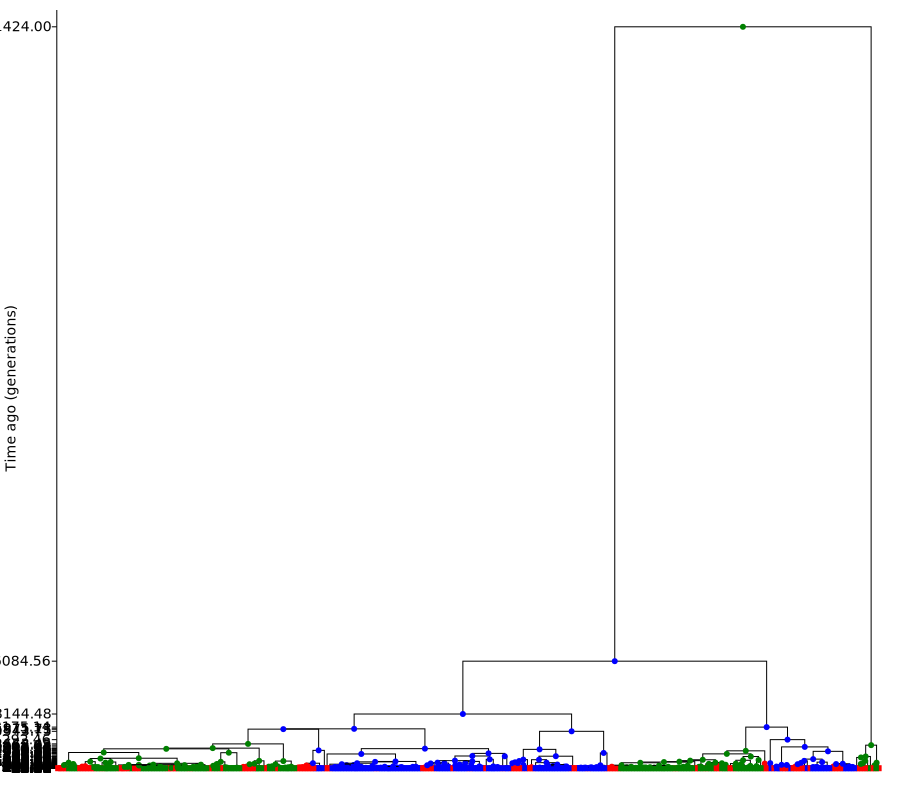

In [3]:
styles = []

for colour, p in zip(['red', 'green', 'blue'], ts.populations()):
    # target the symbols only (class "sym")
    s = f".node.p{p.id} > .sym " + "{" + f"fill: {colour}" + "}"
    styles.append(s)
css_string = " ".join(styles)
#print(f'CSS string applied:\n    "{css_string}"')

ts.first().draw_svg(
    size=(900, 800),
    node_labels={},    
    style=css_string,  # apply tree style
    mutation_labels = {},
    y_axis = True
)

In [4]:
for i in ts.populations():
    print(i)

Population(id=0, metadata={'description': '', 'name': 'pop_0'})
Population(id=1, metadata={'description': '', 'name': 'pop_1'})
Population(id=2, metadata={'description': '', 'name': 'pop_2'})


## (1) island model: contemporaneous, recombinant

In [5]:
# evo model 
seed = 25
#pm_ratio = ?
#mu = ?
#rr = pm_ratio * mu 
rr = 1e-8
length = 1e5

# demographic model 
num_sinks = 2
sizes = [2e3] + [1e3] * num_sinks # constant Ne = [3000.0, 500.0, 500.0]
bg = 1e-6 #background migration rate [everywhere to everywhere] 
demography = msprime.Demography.island_model(initial_size=sizes, migration_rate=bg)

src_sink = 3e-4 # source to sink mig rate
sink_src = 0 # sink to source mig rate
sink_sink = 1e-4 # sink to sink mig rate

# source <-> sink, assymetric
for sink_id in range(1, num_sinks + 1):
    demography.set_migration_rate(source=0,       dest=sink_id, rate=sink_src)  # sink -> source (backwards in time)
    demography.set_migration_rate(source=sink_id, dest=0,       rate=src_sink)  # source -> sink (backwards in time)

# sink <-> sink, symmetric 
sink_ids = list(range(1, num_sinks + 1))
demography.set_symmetric_migration_rate(populations=sink_ids, rate=sink_sink)

# simulate ancestry 
ts = msprime.sim_ancestry(
    samples=[msprime.SampleSet(10, population=p) for p in [1,2]], # 20 samples total
    demography=demography,
    sequence_length=length,
    recombination_rate=rr,
    random_seed=seed,
    record_migrations = True,
    ploidy = 1
)

In [6]:
#ts = msprime.sim_mutations(ts, rate=1e-7, random_seed=25)
samples = list(ts.samples())

In [7]:
print(ts)

╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │         20║
╟───────────────┼───────────╢
║Sequence Length│    100,000║
╟───────────────┼───────────╢
║Time Units     │generations║
╟───────────────┼───────────╢
║Sample Nodes   │         20║
╟───────────────┼───────────╢
║Total Size     │    9.1 KiB║
╚═══════════════╧═══════════╝
╔═══════════╤════╤═════════╤════════════╗
║Table      │Rows│Size     │Has Metadata║
╠═══════════╪════╪═════════╪════════════╣
║Edges      │  97│  3.0 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Individuals│  20│584 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Migrations │  24│  1.0 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Mutations  │   0│ 16 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Nodes      │  56│  1.5 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Populations│   3│306 Bytes│         Yes║
╟───────────┼────┼────

### each node has a population assigned to it. 
i.e. not necessary to traverse migrations object to assign locations for internal nodes

In [8]:
ts.node(45).population

0

In [9]:
ts.migration(5)

Migration(left=50149.0, right=75579.0, node=31, source=1, dest=0, time=626.7912055746187, metadata=b'', id=5)

## tree [styling](https://tskit.dev/tsinfer/docs/latest/usage.html#analysis)

In [10]:
for p in ts.populations():
    print(p)

Population(id=0, metadata={'description': '', 'name': 'pop_0'})
Population(id=1, metadata={'description': '', 'name': 'pop_1'})
Population(id=2, metadata={'description': '', 'name': 'pop_2'})


In [11]:
ts.individual(0)

Individual(id=0, flags=0, location=array([], dtype=float64), parents=array([], dtype=int32), nodes=array([0], dtype=int32), metadata=b'')

In [12]:
# for i in range(0,ts.num_individuals):
#     individual = ts.individual(i) 
#     node = ts.node(individual.nodes[0])
#     population = node.population 

#demography.populations

### node colors

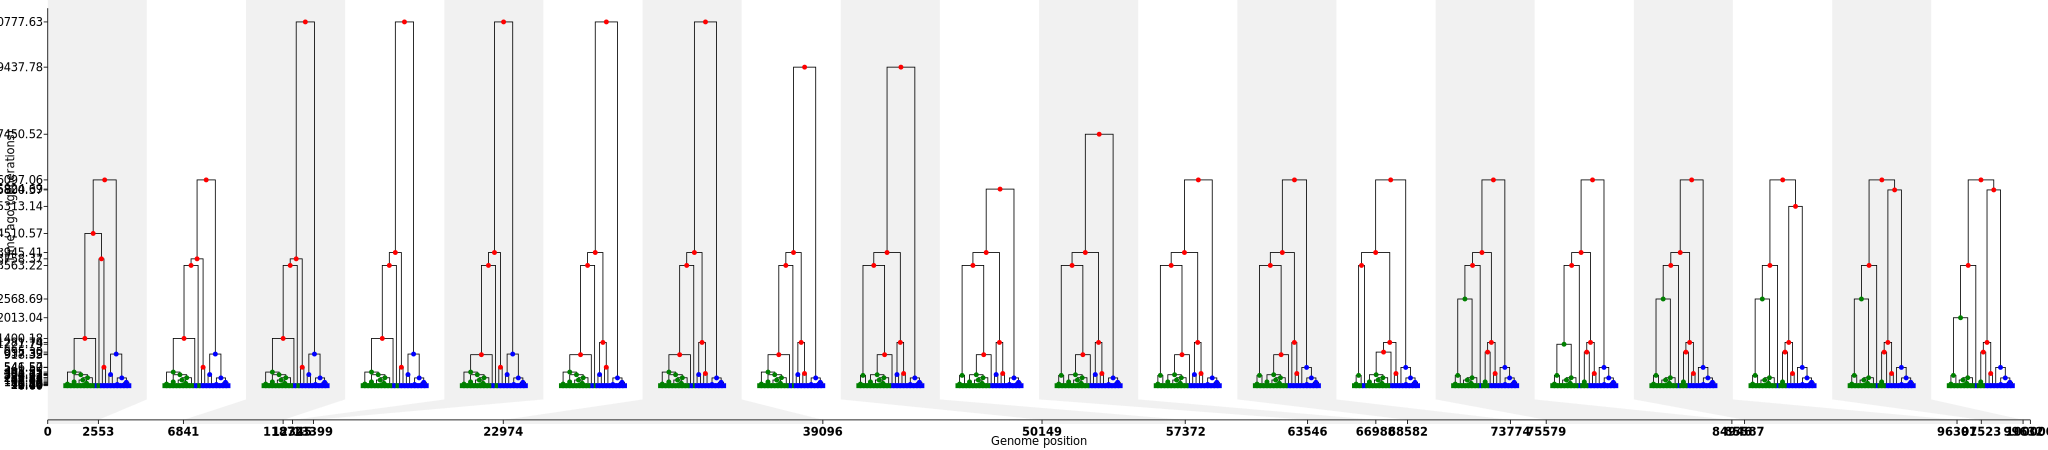

In [13]:
styles = []
# style for each population
for colour, p in zip(['red', 'green', 'blue'], ts.populations()):
    # target the symbols only (class "sym")
    s = f".node.p{p.id} > .sym " + "{" + f"fill: {colour}" + "}"
    styles.append(s)
    #print(f'"{s}" applies to nodes from population {p.metadata["name"]} (id {p.id})')
css_string = " ".join(styles)
#print(f'CSS string applied:\n    "{css_string}"')

ts.draw_svg(
    size=(2500, 550),
    node_labels={},    # Remove all node labels for a clearer viz
    style=css_string,  # Apply the stylesheet
    mutation_labels = {},
    y_axis = True
)

In [14]:
colours = {"pop_0": "red", "pop_1": "green", "pop_2": "blue"}
colours_for_node = {}
for n in ts.samples():
    population_data = ts.population(ts.node(n).population)
    colours_for_node[n] = colours[population_data.metadata["name"]]

individual_for_node = {}
for n in ts.samples():
    individual_data = ts.individual(ts.node(n).individual)
    individual_for_node[n] = individual_data.id

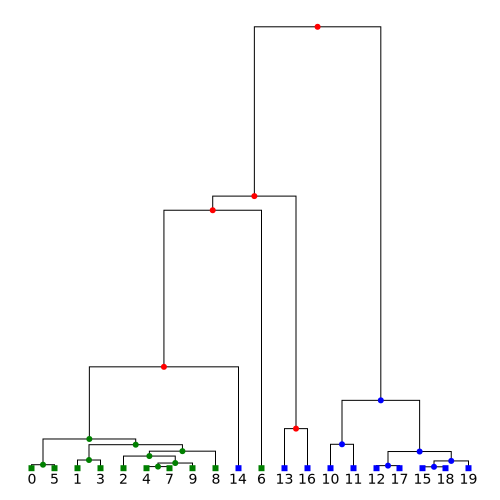

In [15]:
# clear geographic structure here 

ts.at_index(1).draw_svg(#node_colours=colours_for_node, 
    style=css_string,
    node_labels=individual_for_node,
    size=(500, 500)
)

In [16]:
# Plot with tips labeled by population

# tip_lab = {u: f"{u}:p{ts.node(u).population}" for u in ts.samples()}
# ts.at_index(1).draw_svg(node_labels=tip_lab, style=css_string, size = (1500,500))


## function for finding location of mrca for every pair of tips in every tree 

In [17]:
def get_locations_df(ts, samples, trim_flanks = True): 
    type = "inf" 
    if trim_flanks == False:
        type = "sim"
    
    rows = []
    start = 1 if (trim_flanks and ts.num_trees > 2) else 0
    end   = ts.num_trees - 1 if (trim_flanks and ts.num_trees > 2) else ts.num_trees
    for i in range(start, end):
        t = ts.at_index(i)
        L, R = t.interval

        for a, b in combinations(samples, 2):
            u = t.mrca(a, b)
            pop = ts.population(ts.node(u).population).metadata["name"]
            rows.append({
                "index": i, 
                "sample_a": a, 
                "sample_b": b,
                "left": L, 
                "right": R,
                "mrca_population": pop, 
                "type": type
            })
    return pd.DataFrame(rows)

In [18]:
loc_df = get_locations_df(ts, samples, trim_flanks = False)
loc_df

,index,sample_a,sample_b,left,right,mrca_population,type
0,0,0,1,0.0,2553.0,pop_1,sim
1,0,0,2,0.0,2553.0,pop_1,sim
2,0,0,3,0.0,2553.0,pop_1,sim
3,0,0,4,0.0,2553.0,pop_1,sim
4,0,0,5,0.0,2553.0,pop_1,sim
...,...,...,...,...,...,...,...
3795,19,16,18,99632.0,100000.0,pop_0,sim
3796,19,16,19,99632.0,100000.0,pop_0,sim
3797,19,17,18,99632.0,100000.0,pop_2,sim
3798,19,17,19,99632.0,100000.0,pop_2,sim


### locations for a given pair aren't consistent! 
i.e. we can see local variation across the tree sequence

In [19]:
counts = pd.DataFrame(loc_df.groupby(['sample_a', 'sample_b', 'mrca_population'])['mrca_population'].count())
counts

mrca_population
sample_a sample_b mrca_population                 
0        1        pop_0                         12
                  pop_1                          8
         2        pop_0                          6
                  pop_1                         14
         3        pop_0                         12
...                                            ...
16       18       pop_0                         20
         19       pop_0                         20
17       18       pop_2                         20
         19       pop_2                         20
18       19       pop_2                         20

[232 rows x 1 columns]

In [20]:
# visualize location counts where sample a = 0
#counts['mrca_population'][0]

In [21]:
ts

### export trees for gaia 

In [22]:
# 27 01 2026
#ts.dump("demo.trees")

In [454]:
demography.migration_matrix

array([[0.    , 0.    , 0.    ],
       [0.0003, 0.    , 0.0001],
       [0.0003, 0.0001, 0.    ]])

# future

## binning ... 

In [ ]:
# insert function for binning tree sequence and re-identifying mrca locations

## validation: proportion of correctly labeled mrca locations 

In [ ]:
# insert functions for inferring/dating tree sequence

In [266]:
# insert function for comparing inferred mrca_locations to truth